In [49]:
import matplotlib.pyplot as plt
import PIL

In [50]:
import torch, torchvision
import numpy as np
rng = np.random.default_rng()
import time
from tqdm.notebook import tqdm   ### suitable for notebooks

In [51]:
fname = 'EMNIST_torch'

### Download and initialize datasets
TrainDS_orig = torchvision.datasets.EMNIST(fname, train=True, download=True, split='letters', transform=torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img)
                ]))
TestDS_orig = torchvision.datasets.EMNIST(fname, train=False, split='letters', transform=torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img)
                ]))

A - 1

B - 2

.
.
.
.

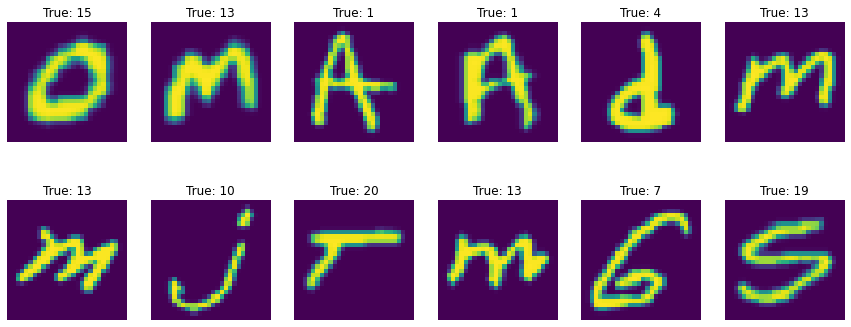

In [52]:
### Plot examples
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
for axes_row in axes:
    for ax in axes_row:
        test_index = rng.integers(0, len(TestDS_orig))
        image, orig_label = TestDS_orig[test_index]
        ax.set_axis_off()
        ax.imshow(image)
#         ax.imshow(PIL.ImageOps.mirror(image.rotate(-90)))
        ax.set_title('True: %i' % orig_label)

In [53]:
### Define the label transform from an integer to a set of probabilities
def target_transform(inlabel):
    newlabel = torch.zeros(27)
    newlabel[inlabel] = 1.
    return newlabel

def input_transform(image):
    image = torchvision.transforms.functional.rotate(image,-90)
    image = torchvision.transforms.functional.hflip(image)
    tensor = torchvision.transforms.functional.to_tensor(image)
    return tensor

### Reinitialize datasets with the transforms
TrainDS = torchvision.datasets.EMNIST(fname, train=True, download=True,
            target_transform=target_transform, transform=torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.0), (1.0))
                ]), split='letters')
TestDS = torchvision.datasets.EMNIST(fname, train=False,
            target_transform=target_transform, transform=torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.0), (1.0))
                ]), split='letters')

### Initialize DataLoaders as PyTorch convenience
TrainDL = torch.utils.data.DataLoader(TrainDS, shuffle=True, batch_size=32)
TestDL = torch.utils.data.DataLoader(TestDS, batch_size=1000)

### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

### Define the dense neuron layer
# Network = torch.nn.Sequential(
#     torch.nn.Flatten(),            # 28x28 -> 784
#     torch.nn.Linear(784, 10),      # 784 -> 10
#     torch.nn.Softmax(dim=1)
# )
Network = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 400),
    torch.nn.ReLU(),
    torch.nn.Linear(400, 27),
    torch.nn.Softmax(dim=1)
)
Network.to(device=device)

### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
crit = torch.nn.BCELoss()
opt = torch.optim.SGD(Network.parameters(), lr=0.3)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=400, bias=True)
  (2): ReLU()
  (3): Linear(in_features=400, out_features=27, bias=True)
  (4): Softmax(dim=1)
)
324827 trainable parameters


In [54]:
### Baseline: just say it's anything at probability 1/N, what's the loss?
N = 27
labels = torch.zeros(1, 27, dtype=torch.float32)
labels[0, 3] = 1.
output = torch.full_like(labels, 1./N)
print(crit(output, labels))

tensor(0.1584)


In [55]:
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, 17)

### Train the model
for e in tqdm(epochs):
    tr_loss = 0.
    samples = 0
    ### Loop over batches
    for inputs, labels in tqdm(TrainDL, leave=False):
        opt.zero_grad() # zero gradient values
        inputs = inputs.to(device=device) # move input and label tensors to the device with the model
        labels = labels.to(device=device)
        outputs = Network(inputs) # compute model outputs
        loss = crit(outputs, labels) # compute batch loss
        loss.backward() # back-propagate the gradients
        opt.step() # update the model weights
        tr_loss += loss.clone().cpu().item()*len(inputs) # add the batch loss to the running loss
        samples += len(inputs) # update the number of processed samples
    tr_loss /= samples # compute training loss
    print(e, tr_loss)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3900 [00:00<?, ?it/s]

1 0.08243802465116366


  0%|          | 0/3900 [00:00<?, ?it/s]

2 0.05355537265586929


  0%|          | 0/3900 [00:00<?, ?it/s]

3 0.04274488060759046


  0%|          | 0/3900 [00:00<?, ?it/s]

4 0.035813309307425066


  0%|          | 0/3900 [00:00<?, ?it/s]

5 0.03139870734527134


  0%|          | 0/3900 [00:00<?, ?it/s]

6 0.028415565041777415


  0%|          | 0/3900 [00:00<?, ?it/s]

7 0.02618818177555043


  0%|          | 0/3900 [00:00<?, ?it/s]

8 0.024467147057637192


  0%|          | 0/3900 [00:00<?, ?it/s]

9 0.02305618912100983


  0%|          | 0/3900 [00:00<?, ?it/s]

10 0.021945303013751236


  0%|          | 0/3900 [00:00<?, ?it/s]

11 0.020940248639836238


  0%|          | 0/3900 [00:00<?, ?it/s]

12 0.02011983825066963


  0%|          | 0/3900 [00:00<?, ?it/s]

13 0.01938832346033544


  0%|          | 0/3900 [00:00<?, ?it/s]

14 0.01873257686372082


  0%|          | 0/3900 [00:00<?, ?it/s]

15 0.01813905841903761


  0%|          | 0/3900 [00:00<?, ?it/s]

16 0.0176088950307801


In [56]:
### Set model in evaluation mode
Network.eval()

### Compute the test loss
with torch.no_grad():
    te_loss = 0.
    samples = 0
    accuracy = 0
    ### Loop over batches
    for inputs, labels in tqdm(TestDL):
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = Network(inputs)
        loss = crit(outputs, labels)
        te_loss += loss.clone().cpu().item()*len(inputs)
        accuracy += torch.sum(torch.eq(torch.max(labels, 1)[1], torch.max(outputs, 1)[1]), dtype=int).clone().cpu().item()
        samples += len(inputs)
    te_loss /= samples
    accuracy /= samples
    print('Test loss: %f, accuracy: %f' % (te_loss, accuracy))

  0%|          | 0/21 [00:00<?, ?it/s]

Test loss: 0.020812, accuracy: 0.899423


In [57]:
torch.save(Network, 'model_torch_EMNIST_letters_0.chk')

In [58]:
Network = torch.load('model_torch_EMNIST_letters_0.chk')
device='cpu'

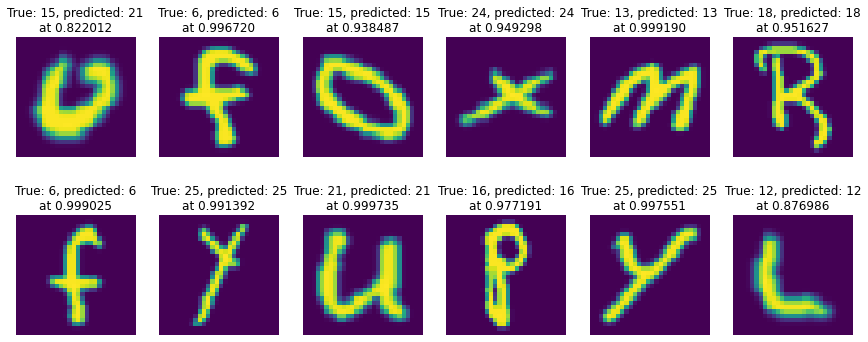

In [108]:
### Draw some random images from the test dataset and compare the true labels to the network outputs
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
### Loop over subplots
for axes_row in axes:
    for ax in axes_row:
        ### Draw the images
        test_index = rng.integers(0, len(TestDS))
        sample, label = TestDS[test_index]
        image, orig_label = TestDS_orig[test_index]
        ### Compute the predictions
        with torch.no_grad():
            output = Network(torch.unsqueeze(sample, dim=0).to(device=device))
            certainty, output = torch.max(output[0], 0)
            certainty = certainty.clone().cpu().item()
            output = output.clone().cpu().item()
        ### Show image
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i, predicted: %i\nat %f' % (orig_label, output, certainty))

tensor([[0.0030, 0.0122, 0.0034, 0.0093, 0.0101, 0.0044, 0.0438, 0.0054, 0.1416,
         0.2295, 0.0741, 0.0227, 0.1240, 0.0018, 0.0756, 0.0222, 0.0174, 0.0045,
         0.0115, 0.0077, 0.0401, 0.0324, 0.0573, 0.0030, 0.0202, 0.0166, 0.0060]])
9
I
tensor([0.2295, 0.1416, 0.1240])
tensor([ 9,  8, 12])
I
H
L


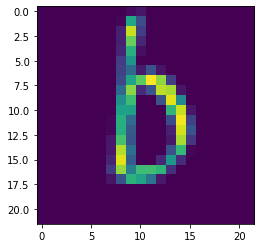

In [115]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

width = 200  # canvas width
height = 200 # canvas height
center = height//2
white = (255, 255, 255) # canvas back

def save():
    # save image to hard drive
    filename = "user_input.jpg"
    output_image.save(filename)
    compressed_output_image = output_image.resize((22,22))
    # Enhance Saturation
#     converter = PIL.ImageEnhance.Color(compressed_output_image)
#     compressed_output_image = converter.enhance(2.5)
    # Enhance contrast
#     converter = PIL.ImageEnhance.Contrast(compressed_output_image)
#     compressed_output_image = converter.enhance(3.5)
    plt.imshow(compressed_output_image, cmap='viridis')
    convert_tensor = torchvision.transforms.ToTensor()
    tensor_image = convert_tensor(compressed_output_image)
    convert_tensor = torchvision.transforms.Normalize((0.0), (1.0))
    tensor_image = convert_tensor(tensor_image)
    tensor_image = torch.nn.functional.pad(tensor_image, (3,3,3,3), "constant", 0)
    # Debugging
    # print(np.array(compressed_output_image.getdata())) # Get data values)
    # print(np.array(image.getdata()))

    ### Compute the predictions
    with torch.no_grad():
        output0 = Network(torch.unsqueeze(tensor_image, dim=0).to(device=device))
        print(output0)
        certainty, output = torch.max(output0[0], 0)
        certainty = certainty.clone().cpu().item()
        output = output.clone().cpu().item()
        certainty1, output1 = torch.topk(output0[0],3)
        certainty1 = certainty1.clone().cpu()#.item()
        output1 = output1.clone().cpu()#.item()
#     print(certainty)
    print(output)
    print(chr(ord('@')+output))
        
    print(certainty1)
    print(output1)
    for i in output1:
        print(chr(ord('@')+i))

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
    canvas.create_oval(x1, y1, x2, y2, fill="white",width=14)
    draw.line([x1, y1, x2, y2],fill="white",width=14)

master = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(master, width=width, height=height, bg='white')
canvas.pack()

# create an empty PIL image and draw object to draw on
output_image = PIL.Image.new("L", (width, height), 0)
draw = ImageDraw.Draw(output_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# add a button to save the image
button=Button(text="save",command=save)
button.pack()

master.mainloop()

In [13]:
# Debugging
# plt.imshow(image, cmap='viridis')

# References:
https://stackoverflow.com/questions/59535286/improve-real-life-results-of-neural-network-trained-with-mnist-dataset